# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (ie 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - 
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Table of contents <a id='top'>

- 1. [EDA](#eda)
    - 1.1. [Portfolio](#portfolio)
    - 1.2. [Profile](#profile)
    - 1.3. [Transcript](#transcript)
- 2. [Preprocessing](#preprocessing)
- 3. ["Offer success" dataset](#offer_success)
- 4. [Clustering](#clustering)
- 5. [Lagged features](#lagged)

In [5]:
import pandas as pd
import numpy as np
import math
import json
import os
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='solarizedd')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

import data_utils_mt.utils as utils
import seaborn as sns
from sklearn.pipeline import Pipeline
import datetime as dt
from xgboost import XGBClassifier

ROOT_DIR = '..'
DATA_DIR = os.path.join(ROOT_DIR, 'data')
DATA_RAW = os.path.join(DATA_DIR, 'raw')
DATA_INTERIM = os.path.join(DATA_DIR, 'interim')
DATA_EXTERNAL = os.path.join(DATA_DIR, 'external')
DATA_PROCESSED = os.path.join(DATA_DIR, 'processed')
SRC = os.path.join(ROOT_DIR, 'src')

STATIC_DATASET_PATH = os.path.join(DATA_PROCESSED, 'static_cluster3d.pkl')

import sys
sys.path.append(SRC)

import src.data.preprocessing as pp
import src.data.success_dataset as sd
import src.data.missing_data as md
import src.evaluation.offer_success as evos
from sklearn.cluster import KMeans

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# read in the json files
portfolio = pd.read_json(os.path.join(DATA_RAW, 'portfolio.json'), orient='records', lines=True)
profile = pd.read_json(os.path.join(DATA_RAW, 'profile.json'), orient='records', lines=True)
transcript = pd.read_json(os.path.join(DATA_RAW, 'transcript.json'), orient='records', lines=True)

# 1. EDA

## 1.1. Portfolio <a id='portfolio'></a>
[Top](#top)

In [11]:
print(portfolio.shape)
portfolio.sort_values(by='offer_type')

(10, 6)


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0


Let's substitute the "channels" column with one hot encoded columns.

In [12]:
portfolio = pp.channels_ohe(portfolio)
portfolio

,difficulty,duration,id,offer_type,reward,channel_social,channel_web,channel_mobile,channel_email
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0,1,1,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,0,1,1,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,1,0,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,0,1,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,0,1,1,1


## 1.2. Profile <a id='profile'></a>
[Top](#top)

In [13]:
print(profile.shape)
profile.head()

(17000, 5)


,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [14]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [15]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

The age = 118 looks strange

In [17]:
profile.age.value_counts()[:10]

118    2175
58      408
53      372
51      363
54      359
59      359
57      353
52      351
55      350
56      342
Name: age, dtype: int64

It's almost certain that 118 was the value used for NaNs in the age. It also seems likely that the customers that have any missing data, have all the 'profile' data missing. Let's test that.

In [18]:
profile.age = profile.age.replace(118, np.nan)
profile.isnull().sum(axis=1).unique()

array([3, 0])

That means that customers have 3 missing values or none, as supposed earlier.

Let's separate the customers in those who have missing data and those who don't. If a customer has all its profile missing, and doesn't have any entry in the transcript dataframe, then it should be ignored (as we don't have any information of use about the client). Are there any of those?

In [19]:
profile['missing_demographics'] = profile.isnull().any(axis=1).astype(int)
profile.head()

,age,became_member_on,gender,id,income,missing_demographics
0,NaN,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,1
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,0
2,NaN,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,1
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0
4,NaN,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN,1


In [20]:
utils.common_values(profile.id, transcript.person)

Intersection: 17000
Total set 1: 17000
Not in set 2: 0
Total set 2: 17000
Not in set 1: 0
Total: 17000


All the customers in the "profile" dataframe are in the "transcript" dataframe also. That means all customers give at least some information, and cannot be dropped.

### Let's transform the dates

In [22]:
profile.became_member_on = pd.to_datetime(profile.became_member_on, 
                                          format='%Y%m%d')
profile.head()

,age,became_member_on,gender,id,income,missing_demographics
0,NaN,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,1
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,0
2,NaN,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,1
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0
4,NaN,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN,1


### And encode the gender

In [23]:
gender_dict = {'F': 0, 'M': 1, 'O': 2, None: np.nan}
gender_dict_inverse = {0: 'F', 1: 'M', 2: 'O', np.nan: None}
profile.gender = profile.gender.replace(gender_dict)
profile.head()

,age,became_member_on,gender,id,income,missing_demographics
0,NaN,2017-02-12,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,1
1,55.0,2017-07-15,0.0,0610b486422d4921ae7d2bf64640c50b,112000.0,0
2,NaN,2018-07-12,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,1
3,75.0,2017-05-09,0.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0
4,NaN,2017-08-04,NaN,a03223e636434f42ac4c3df47e8bac43,NaN,1


### Let's find a good format to use the dates in the estimators

In [25]:
# Create a feature that shows when a customer became member, 
# as the number of days since January 1st, 1970, to the signup date.
profile['member_since_epoch'] = (
    profile.became_member_on - dt.datetime(1970,1,1)).dt.days
profile.head()

,age,became_member_on,gender,id,income,missing_demographics,member_since_epoch
0,NaN,2017-02-12,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,1,17209
1,55.0,2017-07-15,0.0,0610b486422d4921ae7d2bf64640c50b,112000.0,0,17362
2,NaN,2018-07-12,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,1,17724
3,75.0,2017-05-09,0.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,17295
4,NaN,2017-08-04,NaN,a03223e636434f42ac4c3df47e8bac43,NaN,1,17382


### How do the features look like?

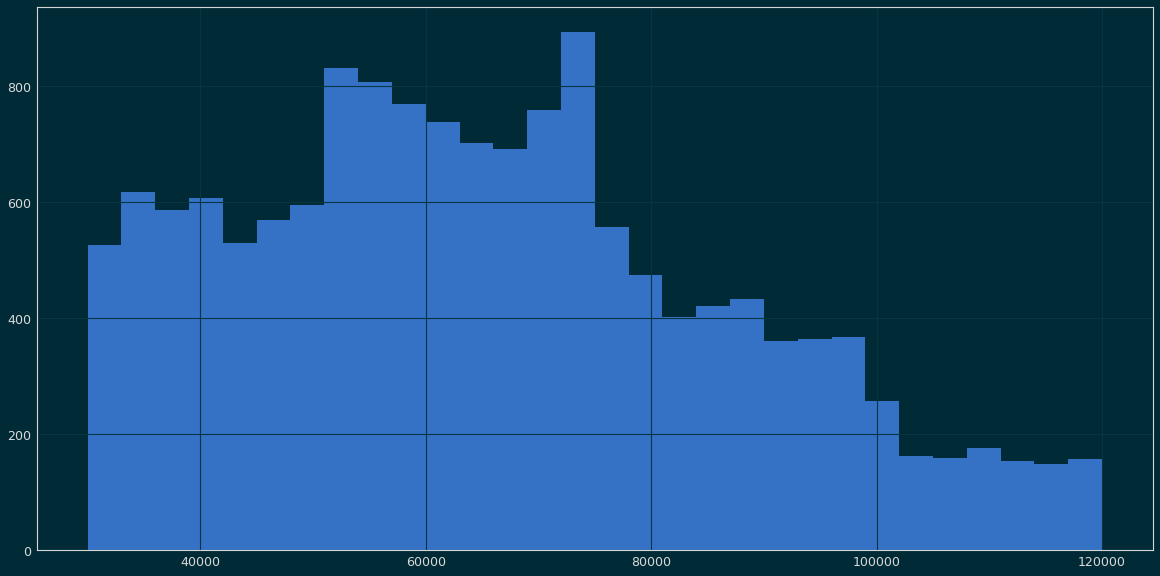

In [26]:
profile.income.hist(bins=30)

In [27]:
profile.gender.value_counts(dropna=False)

 1.0    8484
 0.0    6129
NaN     2175
 2.0     212
Name: gender, dtype: int64

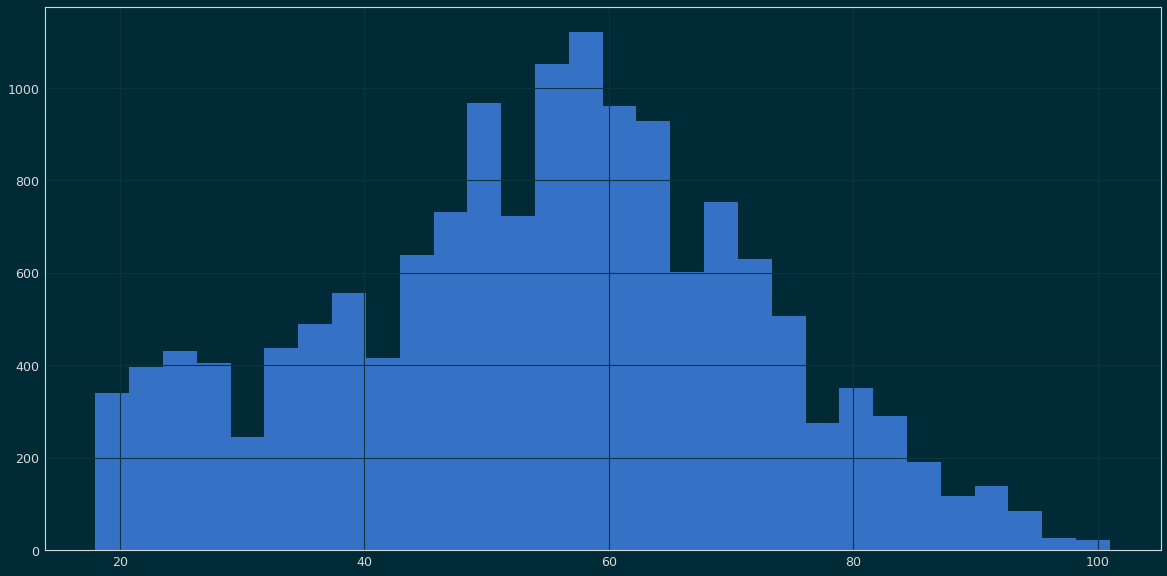

In [28]:
profile.age.hist(bins=30)

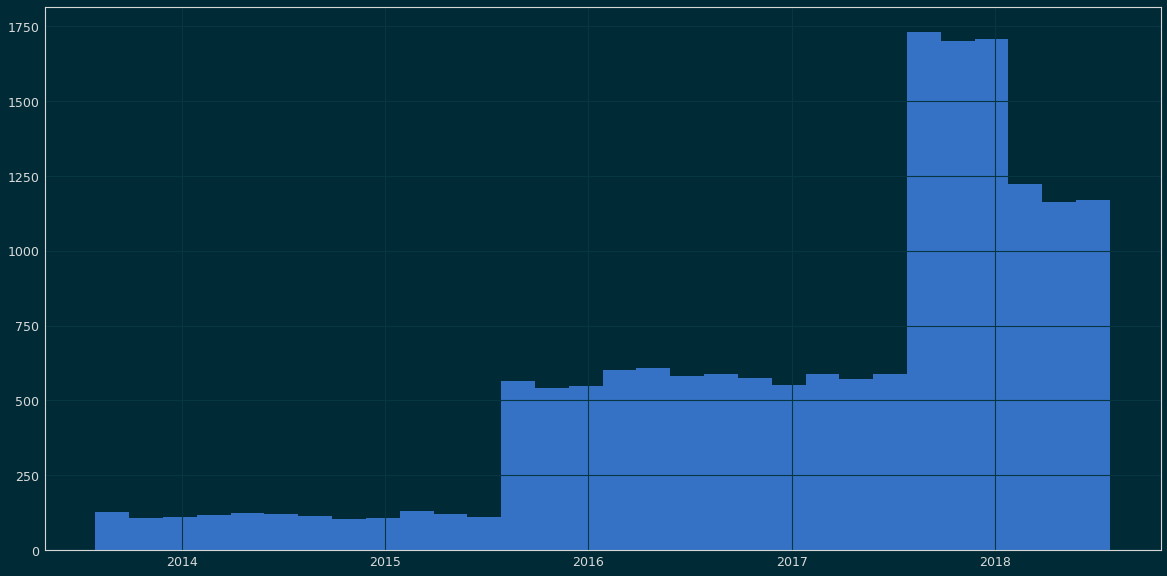

In [29]:
profile.became_member_on.hist(bins=30)

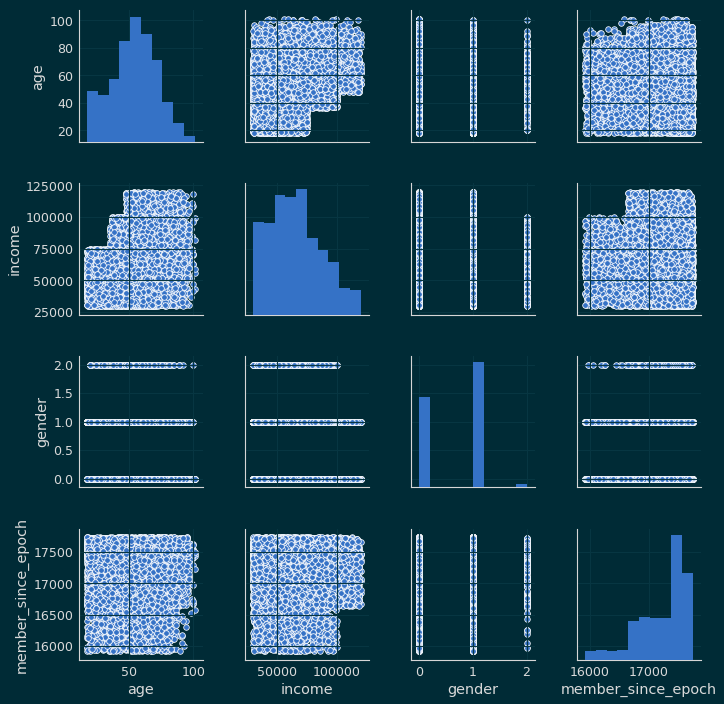

In [30]:
sns.pairplot(profile[['age', 
                      'income', 
                      'gender', 
                      'member_since_epoch']].dropna())

There is a very strange age-income "stair" pattern... I assume that is due to the inner workings of the simulator.

**Finding:** The simulator seems to cap the income for younger customers, in discrete steps.

## 1.3. Transcript <a id='transcript'></a>
[Top](#top)

In [31]:
print(transcript.shape)
transcript.head()

(306534, 4)


,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [32]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [33]:
transcript.time.unique()

array([  0,   6,  12,  18,  24,  30,  36,  42,  48,  54,  60,  66,  72,
        78,  84,  90,  96, 102, 108, 114, 120, 126, 132, 138, 144, 150,
       156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228,
       234, 240, 246, 252, 258, 264, 270, 276, 282, 288, 294, 300, 306,
       312, 318, 324, 330, 336, 342, 348, 354, 360, 366, 372, 378, 384,
       390, 396, 402, 408, 414, 420, 426, 432, 438, 444, 450, 456, 462,
       468, 474, 480, 486, 492, 498, 504, 510, 516, 522, 528, 534, 540,
       546, 552, 558, 564, 570, 576, 582, 588, 594, 600, 606, 612, 618,
       624, 630, 636, 642, 648, 654, 660, 666, 672, 678, 684, 690, 696,
       702, 708, 714])

In [34]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

Let's get the "value" data out of the dictionaries, and then check each type of event separately.

In [35]:
transcript = pp.unwrap_transcript(transcript)

In [36]:
transcript[transcript.event == 'offer received'].head()

,event,person,time,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [37]:
transcript[transcript.event == 'offer viewed'].head()

,event,person,time,amount,offer_id,reward
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,NaN,ae264e3637204a6fb9bb56bc8210ddfd,NaN
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN


In [38]:
transcript[transcript.event == 'transaction'].head()

,event,person,time,amount,offer_id,reward
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,0.83,NaN,NaN
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,NaN,NaN
12659,transaction,54890f68699049c2a04d415abc25e717,0,13.23,NaN,NaN
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,NaN,NaN
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,NaN,NaN


In [39]:
transcript[transcript.event == 'offer completed'].head()

,event,person,time,amount,offer_id,reward
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,NaN,2906b810c7d4411798c6938adc9daaa5,2.0
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10.0
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0


The "event" column could be Label-encoded but, other than that, there don't seem to be many simple preprocessing actions to take. There is still a lot of data wrangling before having a well posed problem, though.

Let's make a dataset that doesn't take into account the particular person or offer, but rather their features.

In [41]:
static_df = pp.join_data(transcript, profile, portfolio)
static_df.head()

,event,time,amount,reward,age,became_member_on,gender,income,missing_demographics,member_since_epoch,difficulty,duration,offer_type,reward_t,channel_social,channel_web,channel_mobile,channel_email
0,offer received,0,NaN,NaN,75.0,2017-05-09,0.0,100000.0,0,17295,5.0,7.0,bogo,5.0,0.0,1.0,1.0,1.0
1,offer received,0,NaN,NaN,NaN,2017-08-04,NaN,NaN,1,17382,20.0,10.0,discount,5.0,0.0,1.0,0.0,1.0
2,offer received,0,NaN,NaN,68.0,2018-04-26,1.0,70000.0,0,17647,10.0,7.0,discount,2.0,0.0,1.0,1.0,1.0
3,offer received,0,NaN,NaN,NaN,2017-09-25,NaN,NaN,1,17434,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0
4,offer received,0,NaN,NaN,NaN,2017-10-02,NaN,NaN,1,17441,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0


In [42]:
static_df.duration.unique()

array([ 7., 10.,  5.,  4.,  3., nan])

### Let's check how often offers are sent to customers, and if the timings are coordinated.

In [45]:
merged_df = pp.join_data(transcript, profile, portfolio, static=False)
merged_df.head()

,event,person,time,amount,offer_id,reward,age,became_member_on,gender,income,missing_demographics,member_since_epoch,difficulty,duration,offer_type,reward_t,channel_social,channel_web,channel_mobile,channel_email
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75.0,2017-05-09,0.0,100000.0,0,17295,5.0,7.0,bogo,5.0,0.0,1.0,1.0,1.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,2017-08-04,NaN,NaN,1,17382,20.0,10.0,discount,5.0,0.0,1.0,0.0,1.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,68.0,2018-04-26,1.0,70000.0,0,17647,10.0,7.0,discount,2.0,0.0,1.0,1.0,1.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,2017-09-25,NaN,NaN,1,17434,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,2017-10-02,NaN,NaN,1,17441,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0


In [46]:
def get_differences(user_events):
    return pd.DataFrame((user_events.time - user_events.time.shift(1)).values)

In [54]:
# "delays" shows the time differences between consecutive offers for each
# user.
sent = merged_df[merged_df.event == 'offer received']
delays = sent.groupby('person').apply(get_differences).rename(
    columns={0: 'diff'})
delays = delays.unstack()
delays.head()

diff                              
                                    0      1      2     3     4   5
person                                                             
0009655768c64bdeb2e877511632db8f  NaN  168.0   72.0  96.0  72.0 NaN
00116118485d4dfda04fdbaba9a87b5c  NaN  408.0    NaN   NaN   NaN NaN
0011e0d4e6b944f998e987f904e8c1e5  NaN  168.0  168.0  72.0  96.0 NaN
0020c2b971eb4e9188eac86d93036a77  NaN  168.0  168.0  72.0  96.0 NaN
0020ccbbb6d84e358d3414a3ff76cffd  NaN  168.0   72.0  96.0   NaN NaN

Text(0.5, 1.0, 'Time difference between two consecutive offers, for each user')

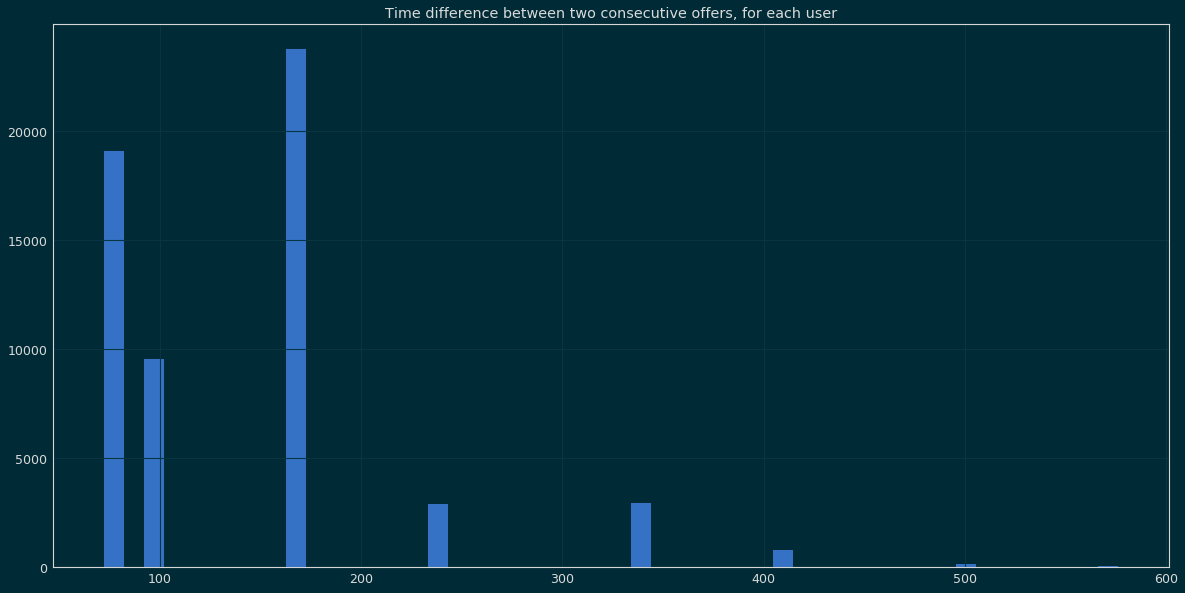

In [55]:
diffs = delays.values.flatten()
diffs = diffs[~np.isnan(diffs)]
diffs = pd.Series(diffs)
diffs.hist(bins=50)
plt.title('Time difference between two consecutive offers, for each user')

In [56]:
diffs.value_counts()

168.0    23754
72.0     19109
96.0      9557
336.0     2942
240.0     2908
408.0      810
504.0      156
576.0       47
dtype: int64

In [57]:
d_vals = diffs.sort_values().unique()
d_vals

array([ 72.,  96., 168., 240., 336., 408., 504., 576.])

In [58]:
d_vals[1:] - d_vals[:-1]

array([24., 72., 72., 96., 72., 96., 72.])

### The offers are being clearly sent in a coordinated fashion, and sent in very specific times. The times are multiples of 24. Let's investigate further.

In [60]:
# Times contains the time at which each offer was sent
times = sent.groupby('person').apply(lambda x: pd.DataFrame(x.time.values)).rename(
    columns={0: 'times'}).unstack()
times.head()

times                                
                                      0      1      2      3      4   5
person                                                                 
0009655768c64bdeb2e877511632db8f  168.0  336.0  408.0  504.0  576.0 NaN
00116118485d4dfda04fdbaba9a87b5c  168.0  576.0    NaN    NaN    NaN NaN
0011e0d4e6b944f998e987f904e8c1e5    0.0  168.0  336.0  408.0  504.0 NaN
0020c2b971eb4e9188eac86d93036a77    0.0  168.0  336.0  408.0  504.0 NaN
0020ccbbb6d84e358d3414a3ff76cffd  168.0  336.0  408.0  504.0    NaN NaN

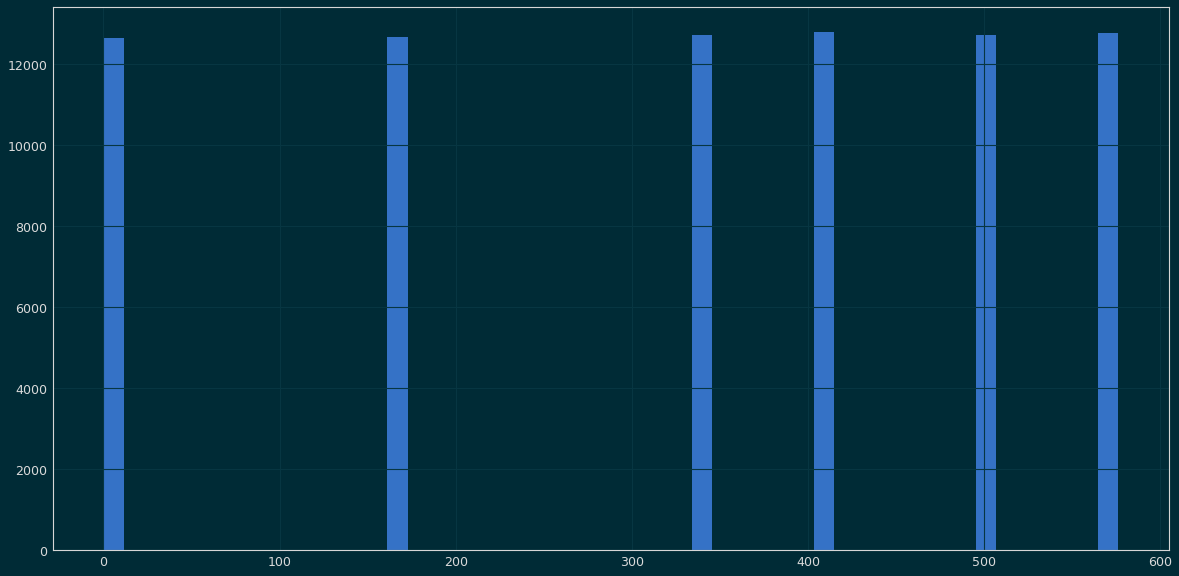

In [62]:
send_times = times.values.flatten()
send_times = pd.Series(send_times[~np.isnan(send_times)])
send_times.hist(bins=50)

In [64]:
send_times.value_counts()

408.0    12778
576.0    12765
336.0    12711
504.0    12704
168.0    12669
0.0      12650
dtype: int64

Let's check if they are all multiples of 24.

In [66]:
time_values = send_times.sort_values().unique()
time_values / 24

array([ 0.,  7., 14., 17., 21., 24.])

Indeed, all the sending times are multiples of 24 (one day).

### Let's look at the transactions in time, and the effect of the offers.

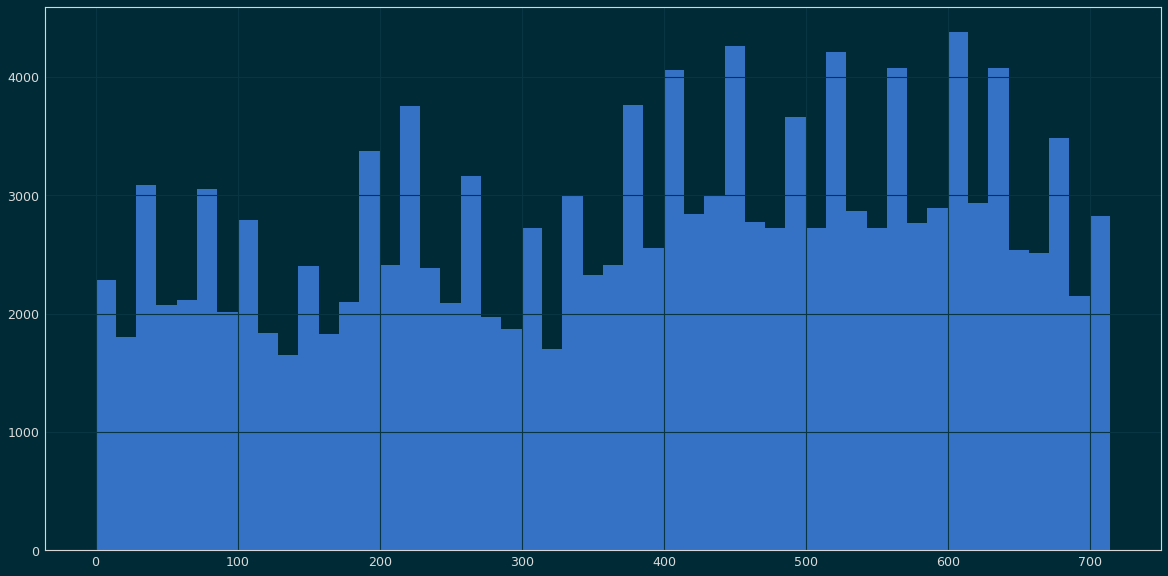

In [67]:
transactions = merged_df[merged_df.event == 'transaction']
transactions.time.hist(bins=50)

In [68]:
transaction_t_values = transactions.groupby('time').time.count()
transaction_t_values.head()

time
0     633
6     797
12    850
18    879
24    922
Name: time, dtype: int64

Transaction times go in steps of size 6, which is the minimum "tick" of simulator (or at least of the dataset provided). That means that transactions occur at any time of the day.

Let's look at the effects of the offers in transactions.

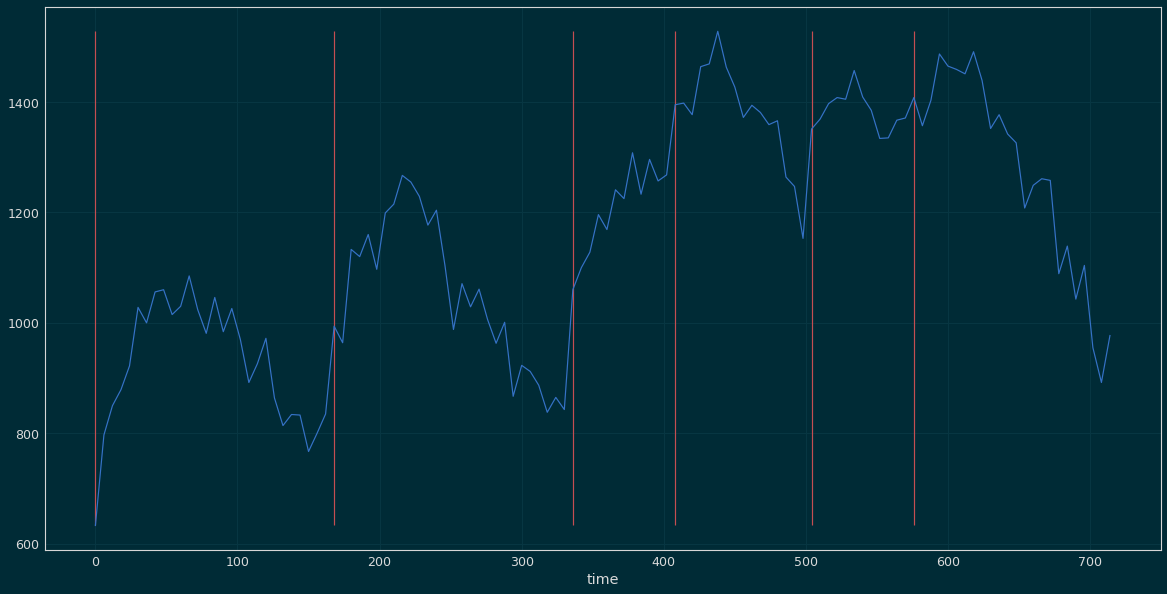

In [69]:
transaction_t_values.plot()
for time_value in time_values:
    plt.vlines(time_value, 
               transaction_t_values.min(),
               transaction_t_values.max(), 'r')

The advertising seems to be having a positive effect, overall. Also, that effect seems to last more than 168 hours after the start of the offer, which is about 7 days. Some offers have a duration of 10 days.

That means that there could be overlapping between the effects of one offer and the next. That should be checked.

Initially, at least, the effect of an offer will be assessed in one particular client, although it is clear that some offers also affect the behavior of other clients. In particular BOGO offers seem to be very suitable to acquire new clients, when an existing customer invites a coffe ("for free") to another person, for example. Perhaps, in future notebooks that effect will be considered, but not initially.

### Is there any overlapping between the effects of offers?

Let's study one case (if there is overlapping in that case, we will know that the simulator makes offers that may overlap. If not, we may look at other customers or find a general procedure to find overlapping in the full dataset.).

In [70]:
person = merged_df[merged_df.person == merged_df.person[0]]
offers = person[person.event.isin(['offer received', 'offer completed'])]
offers = offers[['event', 'time', 'duration', 'offer_id']]
reception = offers[offers.event == 'offer received'].copy()
reception['expected_finish'] = reception.time + 24 * reception.duration
reception

,event,time,duration,offer_id,expected_finish
0,offer received,0,7.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,168.0
53176,offer received,168,3.0,5a8bc65990b245e5a138643cd4eb9837,240.0
150598,offer received,408,7.0,ae264e3637204a6fb9bb56bc8210ddfd,576.0
201572,offer received,504,5.0,f19421c1d4aa40978ebb69ca19b0e20d,624.0


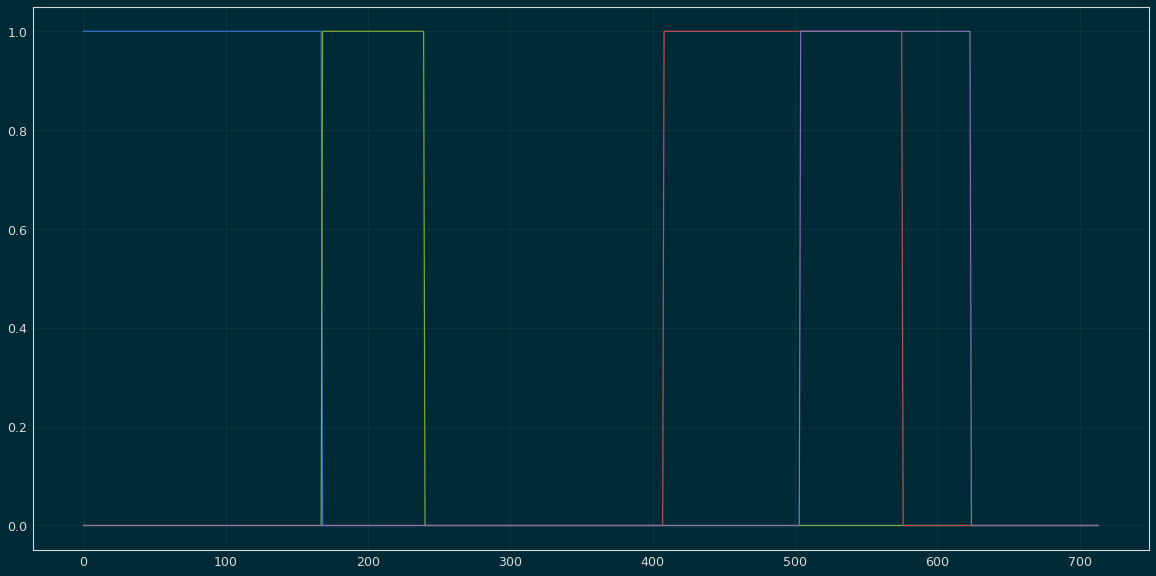

In [72]:
# This plots the times while each offer is "active".
for idx, row in reception.iterrows():
    x = np.arange(merged_df.time.max()).astype(int)  # Total time
    x_on = np.arange(row.time, row.expected_finish).astype(int)  # Time when the offer is "active"
    y = np.zeros(merged_df.time.max())
    y[x_on] = 1
    plt.plot(x, y)

spending = np.zeros(merged_df.time.max())
spending[person.time] = person.amount
plt.plot(x, spending / spending.sum())

There is clear overlapping in that case. That suggests that overlapping of offer effects is not a rare phenomenon, and will obviously introduce some distortions.